# Collinearity

Highly correlated columns in a dataset can lead to multicollinearity issues, which can affect the accuracy and interpretability of models built on the data.

In this section, I will identify the highly correlated columns and remove them where necessary to improve the quality of data.

Any correlation below -0.9 or above 0.9 is possibly too much correlation and will likely need removing.

Correlation below -0.85 or above 0.85 is worth considering but not dropping.

In [1]:
from db_utils import DataTransform, DataFrameInfo, Plotter, DataFrameTransforms, save_changes
import seaborn as sns

dt = DataTransform()
df_info = DataFrameInfo()
visualise = Plotter()
transform = DataFrameTransforms()

df = dt.read_data('outlier_loan_data.csv')

I have sliced the correlation matrix heatmap into two as the dataframe is so big.

/var/folders/p7/7rw6q9xn01xdyk_dn5mrx5k80000gn/T/ipykernel_58214/1517168022.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(df.iloc[:,:20].corr(), annot=True, cmap='coolwarm')


<Axes: >

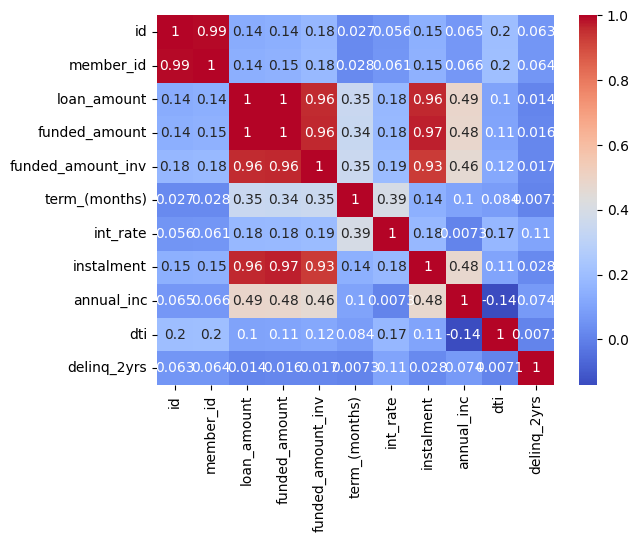

In [2]:
sns.heatmap(df.iloc[:,:20].corr(), annot=True, cmap='coolwarm')

/var/folders/p7/7rw6q9xn01xdyk_dn5mrx5k80000gn/T/ipykernel_58214/181607023.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(df.iloc[:,20:].corr(), annot=True, cmap='coolwarm')


<Axes: >

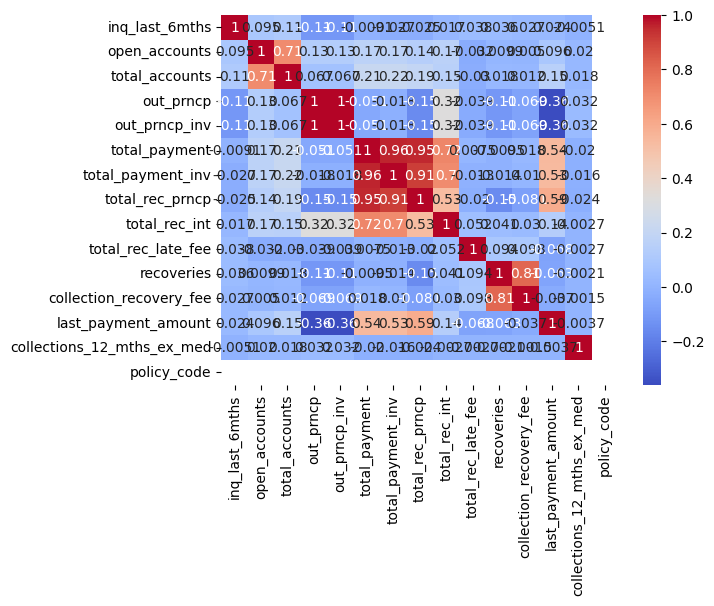

In [3]:
sns.heatmap(df.iloc[:,20:].corr(), annot=True, cmap='coolwarm')

From the heatmaps, I can see that the following columns can be dropped immediately due to extremely high correlation:

- `id` - Correlation of 0.99 with `member_id`
- `funded_amount` - Correlation of 1 with `loan_amount`
- `out_prncp_inv` - Correlation of 1 with `out_prncp`

There are other columns which have high correlation which I would like to dig into deeper before dropping.

Let's select specific columns and take a closer look into their correlation:

<Axes: >

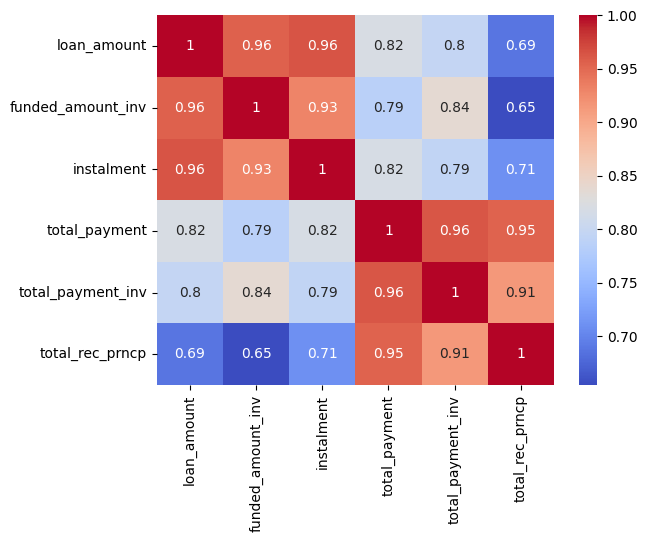

In [4]:
sns.heatmap(df[['loan_amount', 'funded_amount_inv', 'instalment', 'total_payment', 'total_payment_inv', 'total_rec_prncp']].corr(), annot=True, cmap='coolwarm')

`loan_amount`, `funded_amount_inv` and `instalment` all have high correlation so I would like to fit a linear regression model to find out some further information on the relationship between these variables:

In [5]:
df_info.ols_regression(df, 'instalment', 'loan_amount', 'funded_amount_inv')

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             instalment   R-squared:                       0.930
Model:                            OLS   Adj. R-squared:                  0.930
Method:                 Least Squares   F-statistic:                 3.581e+05
Date:                Sun, 05 May 2024   Prob (F-statistic):               0.00
Time:                        18:05:42   Log-Likelihood:                -4943.9
No. Observations:               54150   AIC:                             9894.
Df Residuals:                   54147   BIC:                             9920.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept         -1.596e-06      0.001     -0.001      0.999      -0.002       0.002
loan_amount           0.8719      0.004    223.922      0.000       0.864       0.880
funded_amount_inv     0.0961      0.004     24.669      0.000       0.088       0.104
==============================================================================
Omnibus:                     8735.312   Durbin-Watson:                   1.757
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            18204.313
Skew:                          -0.971   Prob(JB):                         0.00
Kurtosis:                       5.073   Cond. No.                         6.69
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

I will also run an R-Squared models and look at the Variation Inflation Factor (VIF).

R^2 score between 0.5 and 0.99 is acceptable:
- 0.3 < r < 0.5 is weak
- 0.5 < r < 0.7 is moderate
- 0.7 < r < 0.99 is strong and good

VIF score over 10 is considered too high.

In [6]:
funded_inv_and_loan_amount_model = df_info.r_squared_model(df, 'loan_amount', 'funded_amount_inv')
df_info.vif(funded_inv_and_loan_amount_model)

R^2 for model: 
 exog_loan_amount_model: 0.9143967919441581
R^2 model: 0.9143967919441581, VIF score: 11.681805188278295


In [7]:
funded_inv_amount_and_instalment_model = df_info.r_squared_model(df, 'funded_amount_inv', 'instalment')
df_info.vif(funded_inv_amount_and_instalment_model)

R^2 for model: 
 exog_funded_amount_inv_model: 0.8646325250108959
R^2 model: 0.8646325250108959, VIF score: 7.387298906775734


In [8]:
loan_amount_and_instalment_model = df_info.r_squared_model(df, 'loan_amount', 'instalment')
df_info.vif(loan_amount_and_instalment_model)

R^2 for model: 
 exog_loan_amount_model: 0.9289265265511221
R^2 model: 0.9289265265511221, VIF score: 14.06994693624035


The VIF score is over 10 and therefore it is safe to remove the variable.

Now to look at the other three variables of concern:

- `total_payment`
- `total_payment_inv`
- `total_rec_prncp`

In [9]:
total_payment, payment_inv, rec_prncp = df_info.r_squared_multi_model(df, 'total_payment', 'total_payment_inv', 'total_rec_prncp')
df_info.vif(total_payment)
df_info.vif(payment_inv)
df_info.vif(rec_prncp)

R^2 for model: 
 exog_total_payment_model: 0.9600782788636464 
 exog_total_payment_inv_model: 0.9260578334829923 
 exog_total_rec_prncp_model: 0.9119347412431239
R^2 model: 0.9600782788636464, VIF score: 25.0490202209588
R^2 model: 0.9260578334829923, VIF score: 13.52408303819427
R^2 model: 0.9119347412431239, VIF score: 11.3552155993855


Based on my results, I have decided that the following columns can be dropped:


- `id`
- `funded_amount`
- `funded_amount_inv`
- `out_prncp_inv`
- `instalment`
- `total_payment_inv`
- `total_rec_prncp`

In [10]:
columns = ['id', 'funded_amount', 'funded_amount_inv', 'out_prncp_inv', 'instalment', 'total_payment_inv', 'total_rec_prncp']

corr_df = transform.drop_columns(df, columns)

/Users/corynsexton/Documents/Ai_Core/EDA-Customer-Loans-in-Finance/db_utils.py:266: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  mask = np.triu(np.ones_like(df.corr()))
/Users/corynsexton/Documents/Ai_Core/EDA-Customer-Loans-in-Finance/db_utils.py:268: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(df.corr(), annot=True, cmap='coolwarm', mask=mask)


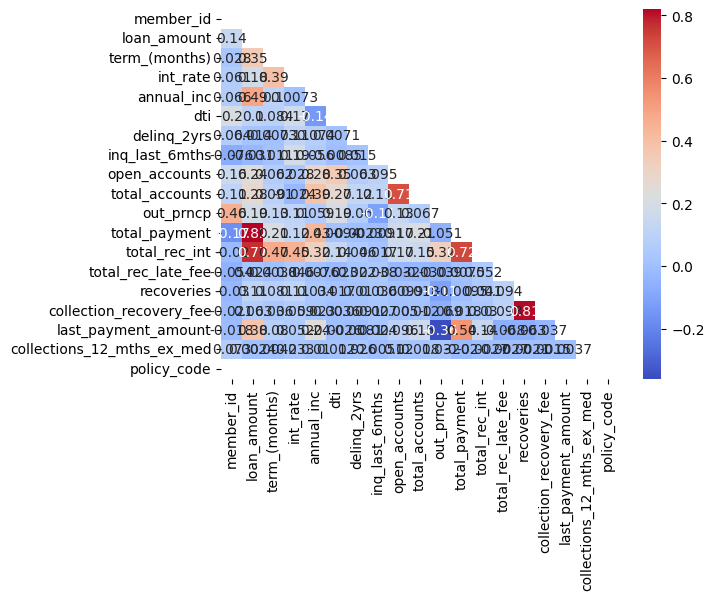

In [11]:
visualise.correlation_heatmap_matrix(corr_df)

I can clearly see from this matrix that there is now no correlation over 0.9 and thereofre I am happy with the data.

In [16]:
save_changes(corr_df, 'transformed_data.csv')